In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
from scipy.stats import pearsonr
from statsmodels.tsa.seasonal import seasonal_decompose


path = os.getcwd() + "\Datasets\\"
#print(os.listdir())
df = pd.read_csv("Indicator.csv")
df.head()
indicator_csvs = [path + i for i in df.Indicator_Code]
df1 = ["\\".join(i.split("\\")) for i in indicator_csvs]
#print(df1)
#To get the population growth CSV
pop_grow = pd.read_csv(df1[0] + "\\" + os.listdir(df1[0])[0])#, sep='delimiter',header=None)#, error_bad_lines=False)

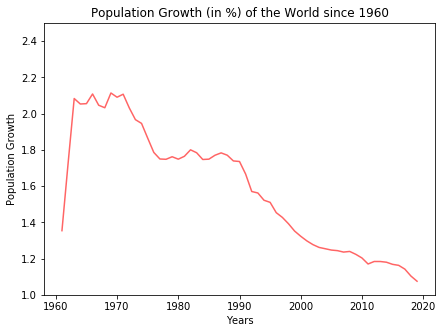

In [2]:
growthWorld = pop_grow[pop_grow["Country Name"]=="World"].iloc[:,5:]
growthWorld.head()

time = [int(i) for i in growthWorld]

plt.figure(figsize=(7,5))
plt.ylim(1,2.5)
plt.ylabel("Population Growth")
plt.xlabel("Years")
plt.title("Population Growth (in %) of the World since 1960")
plt.plot(time,growthWorld.iloc[0,:],color="#ff6565")
plt.show()

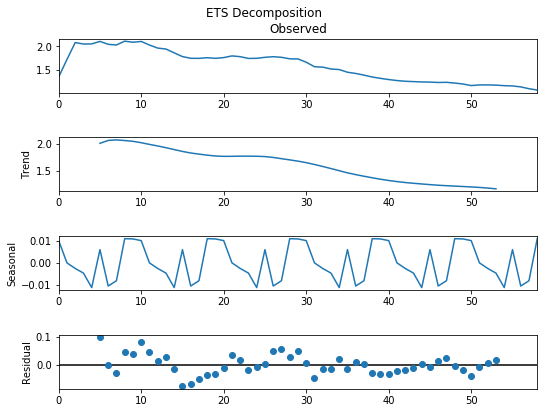

In [3]:
gw = {}
gw["time"] = time
gw["popGrowth"] = growthWorld.iloc[0,:]

gw = pd.DataFrame(gw, columns=["time","popGrowth"])
decompose = seasonal_decompose(gw.popGrowth.values,freq = 10)
ETSPlot = decompose.plot()
ETSPlot.set_figheight(6)
ETSPlot.set_figwidth(8)
ETSPlot.suptitle("ETS Decomposition")
ETSPlot.show()


The above ETS decomposition shows that there is significant trend and seasonality in the data, implying that the time signal is not stationary.

In [4]:
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_model import ARIMA
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

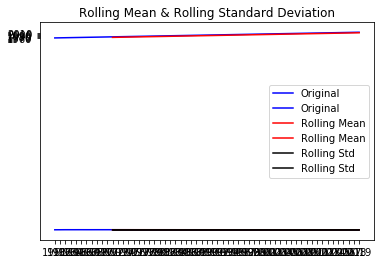

In [5]:
rolling_mean = gw.rolling(window = 12).mean()
rolling_std = gw.rolling(window = 12).std()
plt.plot(gw, color = 'blue', label = 'Original')
plt.plot(rolling_mean, color = 'red', label = 'Rolling Mean')
plt.plot(rolling_std, color = 'black', label = 'Rolling Std')
plt.yticks(np.arange(1960,2020,step = 10))
plt.legend(loc = 'best')
plt.title('Rolling Mean & Rolling Standard Deviation')
plt.show()

In [6]:
result = adfuller(gw['popGrowth'])
print('ADF Statistic: {}'.format(result[0]))
print('p-value: {}'.format(result[1]))
print('Critical Values:')
for key, value in result[4].items():
    print('\t{}: {}'.format(key, value))

ADF Statistic: -0.15646376671526777
p-value: 0.9435159537441833
Critical Values:
	1%: -3.5745892596209488
	5%: -2.9239543084490744
	10%: -2.6000391840277777


The p-value of the resulting Augmented Dickey Fuller test is much higher than 0.05, which also proves the non-stationarity of the model. Due to this, for any forecasting, the ARIMA model has to be used.

In [18]:
trainData = gw.iloc[:48,:]
testData = gw.iloc[48:,:]

### Plotting the ACF and PACF plots to check for stationarity

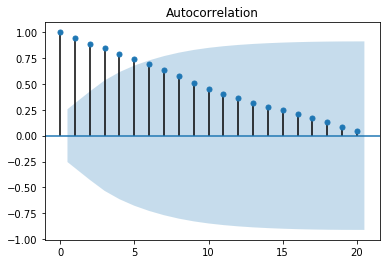

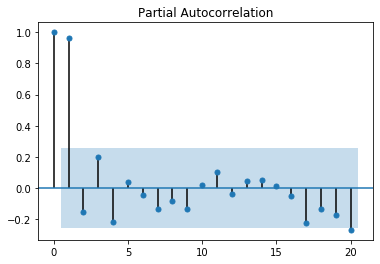

In [16]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

ACFPlot = plot_acf(gw.popGrowth.values, lags=20)
ACFPlot.set_figheight(4)
ACFPlot.set_figwidth(6)
ACFPlot.show()

PACFPlot = plot_pacf(gw.popGrowth.values, lags = 20)
PACFPlot.set_figheight(4)
PACFPlot.set_figwidth(6)
PACFPlot.show()


### Differencing the model to convert it into a stationary signal

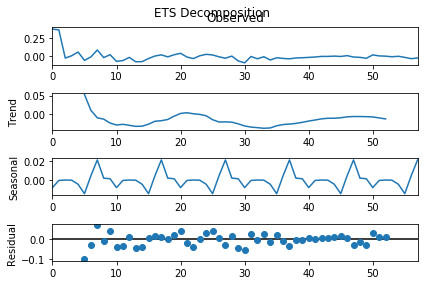

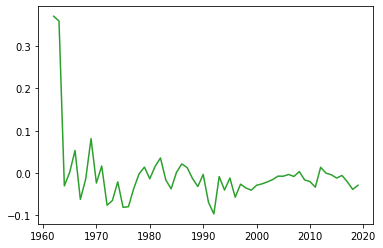

In [38]:
def differencing(series):
    diff = series.diff()
    diff.dropna(inplace=True)
    decompose = seasonal_decompose(diff.values,freq = 10)
    ETSPlot = decompose.plot()
    ETSPlot.set_figheight(4)
    ETSPlot.set_figwidth(6)
    ETSPlot.suptitle("ETS Decomposition")
    ETSPlot.show()

    return diff

diffOne = differencing(gw.popGrowth)
plt.show()
plt.plot(time[1:],diffOne,color="C2")
plt.show()

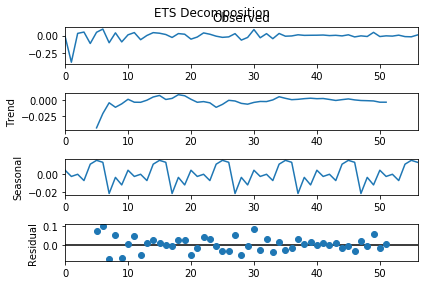

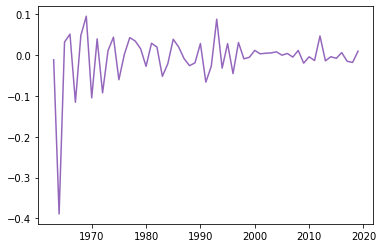

In [39]:
diffTwo = differencing(diffOne)
plt.show()
plt.plot(time[2:],diffTwo,color="C4")
plt.show()

This indicates that the value to be chosen for d is 1.
The p parameter is taken from the PACF curve and results in 3.
The q parameter, taken from the ACF plot results in 1.

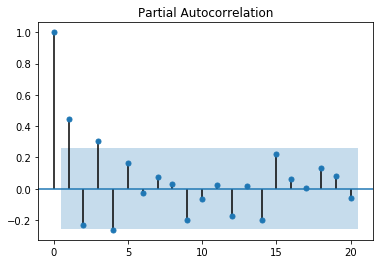

In [42]:
PACFPlot = plot_pacf(diffOne.values, lags = 20)
PACFPlot.set_figheight(4)
PACFPlot.set_figwidth(6)
PACFPlot.show()


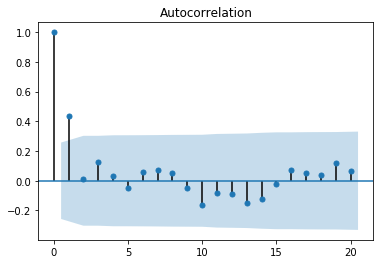

In [43]:
ACFPlot = plot_acf(diffOne.values, lags=20)
ACFPlot.set_figheight(4)
ACFPlot.set_figwidth(6)
ACFPlot.show()

### MODEL: ARIMA(3,1,1)

In [44]:
trainData = gw.iloc[:48,:]
testData = gw.iloc[48:,:]

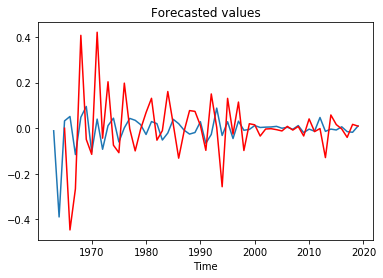

In [93]:
model = ARIMA(diffTwo, order=(3,2,1))
results = model.fit(disp=-1)

plt.title("Forecasted values")
plt.xlabel("Time")
plt.plot(time[2:],diffTwo)
plt.plot(time[4:],results.fittedvalues, color='red')


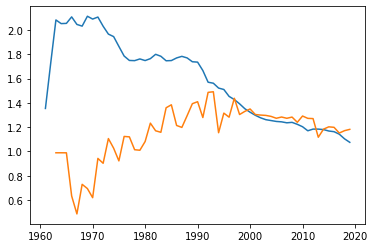

In [95]:
predictions_ARIMA_diff = pd.Series(results.fittedvalues, copy=True)
predictions_ARIMA_diff_cumsum = predictions_ARIMA_diff.cumsum()
predictions_ARIMA_log = pd.Series(diffTwo.iloc[0], index=diffTwo.index)
predictions_ARIMA_log = predictions_ARIMA_log.add(predictions_ARIMA_diff_cumsum, fill_value=0)
predictions_ARIMA = np.exp(predictions_ARIMA_log)
plt.plot(time,gw.popGrowth)
plt.plot(time[2:],predictions_ARIMA)

In [97]:
results.plot_predict(1,69)

ValueError: The start index -1 of the original series  has been differenced away